In [1]:
import geopandas as gpd
import shapely.geometry as Point
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


In [2]:
# API helper - Current Police API has a rate limit of 15 requests per second with a burst of 30
def get_api_response(url, retries = 5, backoff=1):
    for i in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            print(f"You have exceeded the rate limit. Waiting {backoff} seconds...")
            time.sleep(backoff)
            backoff *= 2
        else:
            print(f"Error {response.status_code} - {response.text}")
            return None
    return None

In [3]:
# List of Bristol area outcodes (first half of postcode)
outcodes = ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6', 'BS7', 'BS8', 'BS9', 'BS10', 'BS11', 'BS13', 'BS14', 'BS15', 'BS16', 'BS30', 'BS34']

def fetch_postcodes_from_outcodes(outcodes):
    all_postcodes = []

    for outcode in outcodes:
        url = f"https://api.postcodes.io/outcodes/{outcode}"
        result = get_api_response(url)

        if not result or not result.get('result'):
            continue

        lat = result['result']['latitude']
        lng = result['result']['longitude']

        # Fetch postcodes in this area
        postcodes_response = get_api_response(f"https://api.postcodes.io/postcodes?lon={lng}&lat={lat}&radius=3000")
        data = postcodes_response.get('result', [])

        if not data:
            return []
        
        all_postcodes.extend([p['postcode'] for p in data])
        time.sleep(1)

    return list(set(all_postcodes))

In [4]:
def get_lat_lng(postcode):
    url = f"https://api.postcodes.io/postcodes/{postcode}"
    result = get_api_response(url)
    if result and result.get('result'):
        return result['result']['latitude'], result['result']['longitude']
    return None, None

In [5]:
# Get data for past N months
def generate_months(n):
    base = datetime.today().replace(day=1)
    return [(base - relativedelta(months=i)).strftime("%Y-%m") for i in range(n)]

In [6]:
def fetch_crime_data(postcodes, months):
    all_crimes = []
    lat_lng_cache = {}

    for postcode in postcodes:
        lat, lng = lat_lng_cache.get(postcode, (None, None))
        if not lat:
            lat, lng = get_lat_lng(postcode)
            lat_lng_cache[postcode] = (lat, lng)
        if not lat:
            print(f"Couldn't get location for {postcode}, skipping.")
            continue

        for month in months:
            url = f"https://data.police.uk/api/crimes-street/all-crime?lat={lat}&lng={lng}&date={month}"
            print(f"Fetching crimes for {postcode} ({month})")
            crimes = get_api_response(url)
            if crimes:
                for crime in crimes:
                    crime['postcode'] = postcode
                    crime['month'] = month
                all_crimes.extend(crimes)
            time.sleep(0.2)  # Rate limit protection

    return all_crimes

In [7]:
postcodes = fetch_postcodes_from_outcodes(outcodes)
months = generate_months(8) # Data for past 6 months - sometimes police API is not upto date
crime_data = fetch_crime_data(postcodes, months)


Fetching crimes for BS3 3BU (2025-05)
Error 404 - 
Fetching crimes for BS3 3BU (2025-04)
Fetching crimes for BS3 3BU (2025-03)
Fetching crimes for BS3 3BU (2025-02)
Fetching crimes for BS3 3BU (2025-01)
Fetching crimes for BS3 3BU (2024-12)
Fetching crimes for BS3 3BU (2024-11)
Fetching crimes for BS3 3BU (2024-10)
Fetching crimes for BS6 7EG (2025-05)
Error 404 - 
Fetching crimes for BS6 7EG (2025-04)
Fetching crimes for BS6 7EG (2025-03)
Fetching crimes for BS6 7EG (2025-02)
Fetching crimes for BS6 7EG (2025-01)
Fetching crimes for BS6 7EG (2024-12)
Fetching crimes for BS6 7EG (2024-11)
Fetching crimes for BS6 7EG (2024-10)
Fetching crimes for BS13 9JL (2025-05)
Error 404 - 
Fetching crimes for BS13 9JL (2025-04)
Fetching crimes for BS13 9JL (2025-03)
Fetching crimes for BS13 9JL (2025-02)
Fetching crimes for BS13 9JL (2025-01)
Fetching crimes for BS13 9JL (2024-12)
Fetching crimes for BS13 9JL (2024-11)
Fetching crimes for BS13 9JL (2024-10)
Fetching crimes for BS13 7SL (2025-05)
Er

In [8]:
# Save to file
df = pd.DataFrame(crime_data)
df.to_csv("../data/filton_crime_data.csv", index=False)
print("Crime data saved to ../data/filton_crime_data.csv")
df.head()

Crime data saved to ../data/filton_crime_data.csv


,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,postcode
0,anti-social-behaviour,Force,"{'latitude': '51.433335', 'street': {'id': 227...",,None,,126954199,,2025-03,BS3 3BU
1,anti-social-behaviour,Force,"{'latitude': '51.440866', 'street': {'id': 227...",,None,,126954207,,2025-03,BS3 3BU
2,anti-social-behaviour,Force,"{'latitude': '51.443759', 'street': {'id': 227...",,None,,126954227,,2025-03,BS3 3BU
3,anti-social-behaviour,Force,"{'latitude': '51.449955', 'street': {'id': 227...",,None,,126954709,,2025-03,BS3 3BU
4,anti-social-behaviour,Force,"{'latitude': '51.447320', 'street': {'id': 227...",,None,,126954714,,2025-03,BS3 3BU


In [9]:
df.dtypes

category            object
location_type       object
location            object
context             object
outcome_status      object
persistent_id       object
id                   int64
location_subtype    object
month               object
postcode            object
dtype: object

In [34]:
# Load CSV instead of refetching data for a quick runtime
df = pd.read_csv("../data/filton_crime_data.csv")
df.head()

,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,postcode
0,anti-social-behaviour,Force,"{'latitude': '51.433335', 'street': {'id': 227...",NaN,NaN,NaN,126954199,NaN,2025-03,BS3 3BU
1,anti-social-behaviour,Force,"{'latitude': '51.440866', 'street': {'id': 227...",NaN,NaN,NaN,126954207,NaN,2025-03,BS3 3BU
2,anti-social-behaviour,Force,"{'latitude': '51.443759', 'street': {'id': 227...",NaN,NaN,NaN,126954227,NaN,2025-03,BS3 3BU
3,anti-social-behaviour,Force,"{'latitude': '51.449955', 'street': {'id': 227...",NaN,NaN,NaN,126954709,NaN,2025-03,BS3 3BU
4,anti-social-behaviour,Force,"{'latitude': '51.447320', 'street': {'id': 227...",NaN,NaN,NaN,126954714,NaN,2025-03,BS3 3BU


In [35]:
df.dtypes

category             object
location_type        object
location             object
context             float64
outcome_status       object
persistent_id        object
id                    int64
location_subtype     object
month                object
postcode             object
dtype: object

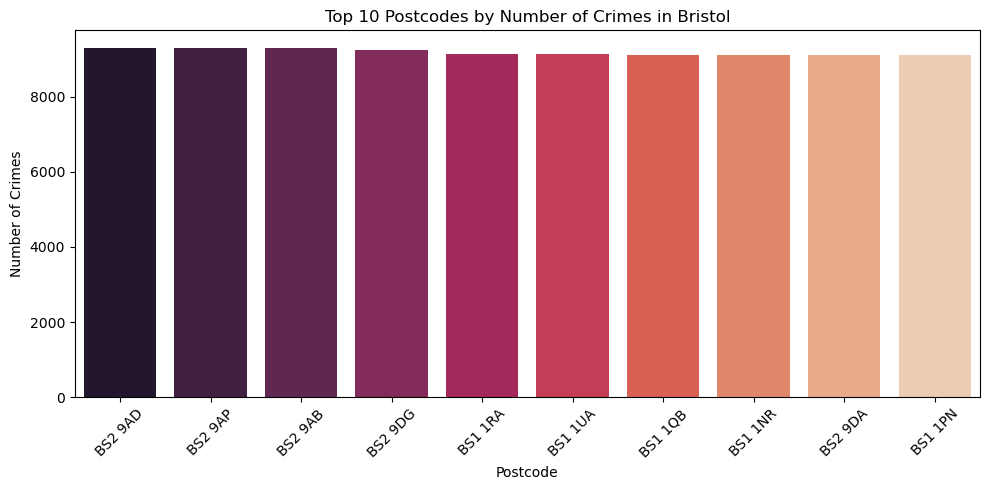

In [36]:
# Top 10 postcodes with most crime
top_postcodes = df['postcode'].value_counts().nlargest(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_postcodes.index, y=top_postcodes.values, palette="rocket")
plt.title('Top 10 Postcodes by Number of Crimes in Bristol')
plt.xlabel('Postcode')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

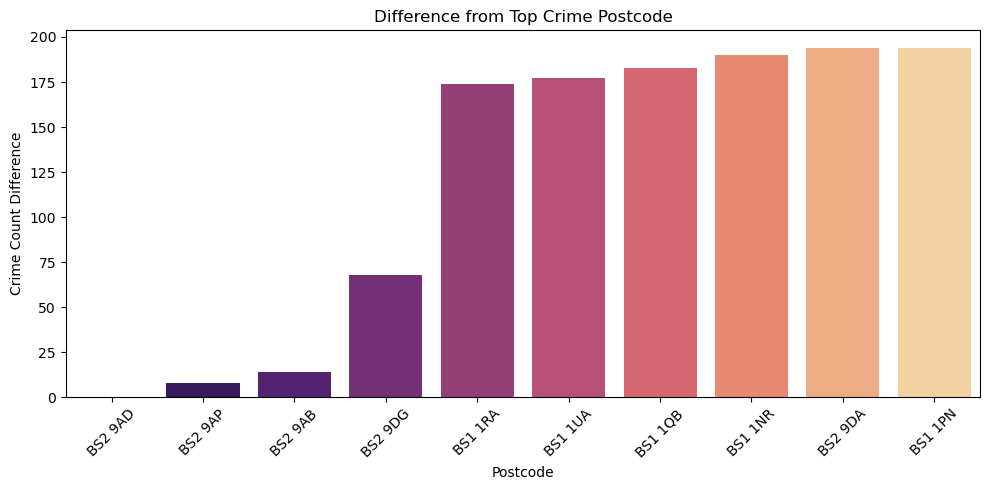

In [37]:
top_value = top_postcodes.values[0]
differences = top_value - top_postcodes.values

plt.figure(figsize=(10, 5))
sns.barplot(x=top_postcodes.index, y=differences, palette="magma")
plt.title('Difference from Top Crime Postcode')
plt.ylabel('Crime Count Difference')
plt.xlabel('Postcode')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

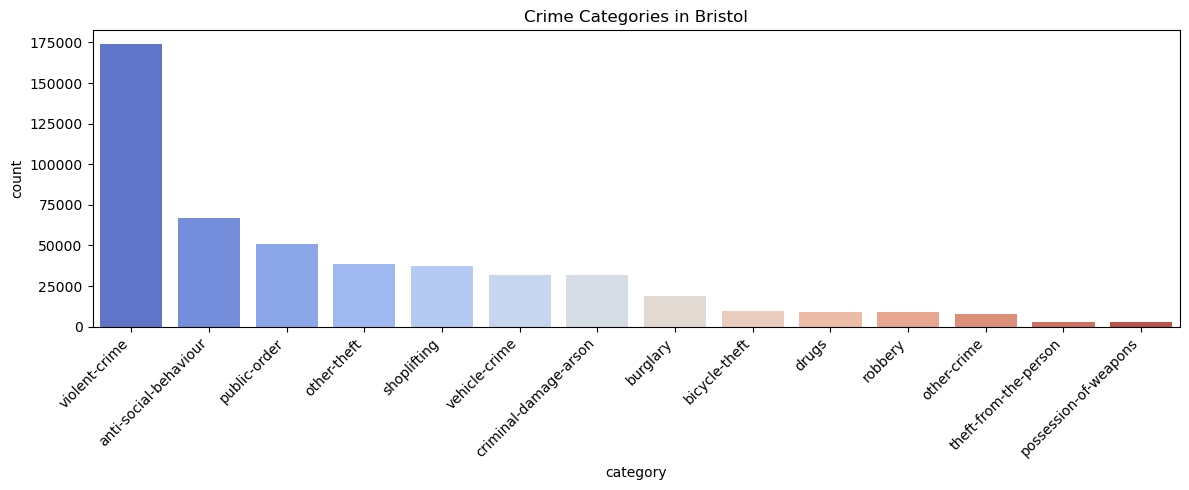

In [38]:
# Crime category vs Number of Crimes
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index, palette="coolwarm")
plt.title('Crime Categories in Bristol')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


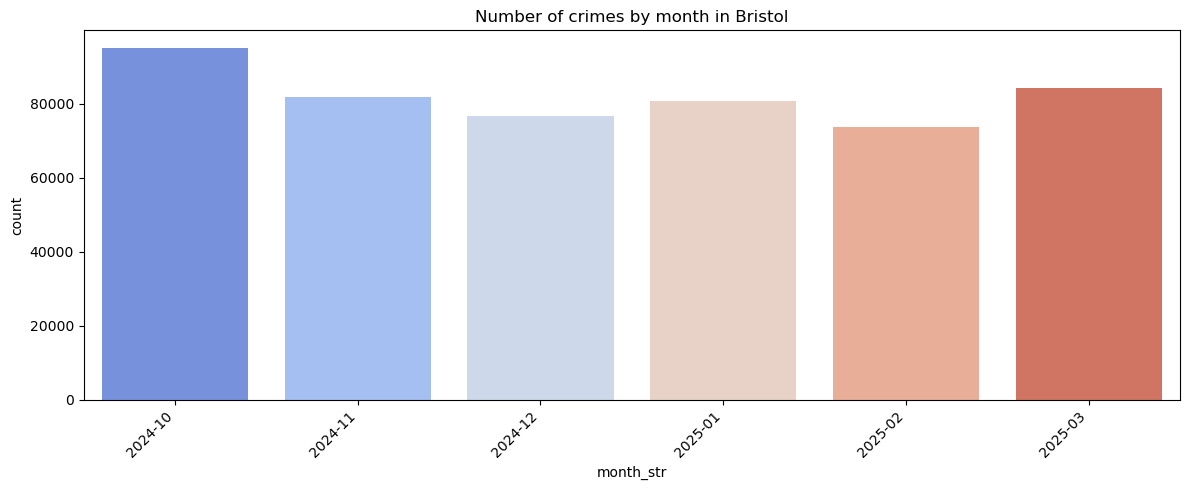

In [41]:
# Crimes by month
df['month'] = pd.to_datetime(df['month'])

# Extract year-month as string for plotting
df['month_str'] = df['month'].dt.strftime('%Y-%m')

# Sort months
sorted_months = df['month'].sort_values().dt.strftime('%Y-%m').unique()

# Plot
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='month_str', order=sorted_months, palette="coolwarm")
plt.title('Number of crimes by month in Bristol')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
# Create map centred on Filton
crime_map = folium.Map(location=[51.454514, -2.587910], zoom_start=14)

import ast

# Convert 'location' column from string to dict if necessary
if isinstance(df['location'].iloc[0], str):
	df['location'] = df['location'].apply(ast.literal_eval)

# Filter out missing data
df = df[df['location'].notnull() & df['location'].apply(lambda loc: loc.get('latitude') and loc.get('longitude'))]

df['lat'] = df['location'].apply(lambda loc: float(loc['latitude']))
df['lng'] = df['location'].apply(lambda loc: float(loc['longitude']))

heat_data = df[['lat', 'lng']].values.tolist()

# Add heat effect to the map
HeatMap(heat_data, radius=15, blur=25, max_zoom=15).add_to(crime_map)

# Save map as HTML
crime_map.save("../assets/filton_crime_map.html")
print("Crime heatmap saved as filton_crime_map.html. Open it in a browser!")

Crime heatmap saved as filton_crime_map.html. Open it in a browser!


In [42]:
# Get all column names
df.columns

Index(['category', 'location_type', 'location', 'context', 'outcome_status',
       'persistent_id', 'id', 'location_subtype', 'month', 'postcode',
       'month_str'],
      dtype='object')

In [43]:
# Shape
df.shape

(492279, 11)

In [44]:
# Replace empty strings with NaN for uniformity
df_cleaned = df.replace('', np.nan)

# Total number of rows with missing values
df_cleaned.isna().sum()

category                 0
location_type            0
location                 0
context             492279
outcome_status       67200
persistent_id        68562
id                       0
location_subtype    490917
month                    0
postcode                 0
month_str                0
dtype: int64

In [ ]:
# Drop irrelevant columns
df_cleaned = df_cleaned.drop(columns=['outcome_status', 'context', 'persistent_id', 'location_subtype', 'location_type', 'month_str'], axis=1)
df_cleaned.head()

,category,location,id,month,postcode,month_str
0,anti-social-behaviour,"{'latitude': '51.433335', 'street': {'id': 227...",126954199,2025-03-01,BS3 3BU,2025-03
1,anti-social-behaviour,"{'latitude': '51.440866', 'street': {'id': 227...",126954207,2025-03-01,BS3 3BU,2025-03
2,anti-social-behaviour,"{'latitude': '51.443759', 'street': {'id': 227...",126954227,2025-03-01,BS3 3BU,2025-03
3,anti-social-behaviour,"{'latitude': '51.449955', 'street': {'id': 227...",126954709,2025-03-01,BS3 3BU,2025-03
4,anti-social-behaviour,"{'latitude': '51.447320', 'street': {'id': 227...",126954714,2025-03-01,BS3 3BU,2025-03


In [46]:
# Regex pattern for YYYY-MM format
pattern = r'^\d{4}-(0[1-9]|1[0-2])$'

# Convert month to string in YYYY-MM format and check validity
month_str = df_cleaned['month'].dt.strftime('%Y-%m')
invalid_count = (~month_str.str.match(pattern)).sum()
print(f"Number of invalid dates: {invalid_count}")

Number of invalid dates: 0


In [23]:
# Seperate Year and Month to different columns
# df_cleaned[["year", "month"]] = df["month"].str.split("-", expand = True)
# df_cleaned.head()

In [47]:
# Count crime categories
crime_category_count = df_cleaned['category'].value_counts()
print(crime_category_count)

violent-crime            173739
anti-social-behaviour     67200
public-order              50840
other-theft               38461
shoplifting               37068
vehicle-crime             32066
criminal-damage-arson     31803
burglary                  19121
bicycle-theft              9423
drugs                      9304
robbery                    9152
other-crime                7934
theft-from-the-person      3086
possession-of-weapons      3082
Name: category, dtype: int64


In [48]:
# Recategorised crimes to imporve generalisation
crime_category_map = {
    'violent-crime': 'violence',
    'robbery': 'violence',
    'shoplifting': 'theft',
    'burglary': 'theft',
    'vehicle-crime': 'theft',
    'bicycle-theft': 'theft',
    'theft-from-the-person': 'theft',
    'other-theft': 'theft',
    'anti-social-behaviour': 'anti-social',
    'public-order': 'anti-social',
    'criminal-damage-arson': 'anti-social',
    'drugs': 'drugs',
    'possession-of-weapons': 'other', 
    'other-crime': 'other'
}

df_cleaned['recategorised_crimes'] = df_cleaned['category'].map(crime_category_map)

# Assign any unmapped crimes to 'other' category
df_cleaned['recategorised_crimes'] = df_cleaned['recategorised_crimes'].fillna('other')

crime_category_count = df_cleaned['recategorised_crimes'].value_counts()
print(crime_category_count)

violence       182891
anti-social    149843
theft          139225
other           11016
drugs            9304
Name: recategorised_crimes, dtype: int64


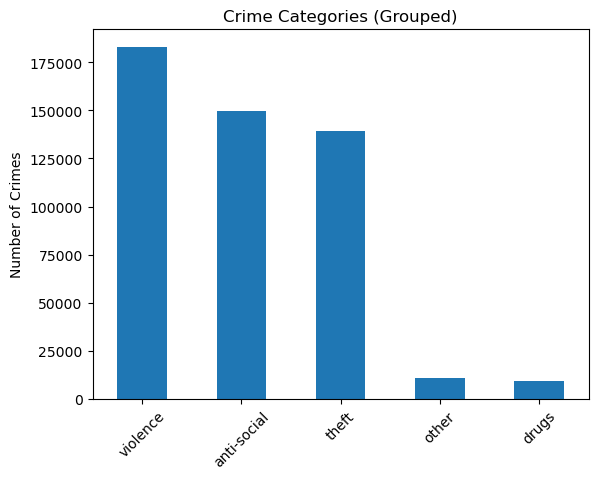

In [49]:
df_cleaned['recategorised_crimes'].value_counts().plot(kind='bar')
plt.title("Crime Categories (Grouped)")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.show()

In [50]:
# Total crimes per postcode
total_crimes_per_postcode = df_cleaned.groupby('postcode').size().reset_index(name='total_crimes')
print(total_crimes_per_postcode)

    postcode  total_crimes
0    BS1 1BU          9088
1    BS1 1DL          9065
2    BS1 1NR          9110
3    BS1 1PN          9106
4    BS1 1QB          9117
..       ...           ...
165  BS9 3RS           915
166  BS9 3RT           918
167  BS9 3SB           945
168  BS9 3SZ           981
169  BS9 3UA           965

[170 rows x 2 columns]


In [51]:
# Top crime category per postcode
top_category_per_postcode = (
    df_cleaned.groupby(['postcode', 'recategorised_crimes']).size().reset_index(name='count').sort_values(['postcode', 'count'], ascending=[True, False]).drop_duplicates('postcode').rename(columns={'recategorised_crimes': 'top_crime_category'}).drop('count', axis=1)
)
print(top_category_per_postcode)

    postcode top_crime_category
0    BS1 1BU        anti-social
5    BS1 1DL        anti-social
10   BS1 1NR        anti-social
15   BS1 1PN        anti-social
20   BS1 1QB        anti-social
..       ...                ...
828  BS9 3RS              theft
833  BS9 3RT              theft
838  BS9 3SB              theft
843  BS9 3SZ              theft
848  BS9 3UA              theft

[170 rows x 2 columns]


In [52]:
# Crimes per postcode per month
monthly_crime = (
    df_cleaned.groupby(['postcode', 'month'])
    .size()
    .reset_index(name='monthly_crimes')
)
print(monthly_crime)

     postcode      month  monthly_crimes
0     BS1 1BU 2024-10-01            1780
1     BS1 1BU 2024-11-01            1518
2     BS1 1BU 2024-12-01            1344
3     BS1 1BU 2025-01-01            1496
4     BS1 1BU 2025-02-01            1388
...       ...        ...             ...
1015  BS9 3UA 2024-11-01             162
1016  BS9 3UA 2024-12-01             174
1017  BS9 3UA 2025-01-01             142
1018  BS9 3UA 2025-02-01             136
1019  BS9 3UA 2025-03-01             164

[1020 rows x 3 columns]


In [ ]:
# # Merge summaries into one master table
# postcode_summary = total_crimes_per_postcode.merge(top_category_per_postcode, on='postcode')
# print(postcode_summary)

    postcode  total_crimes top_crime_category
0    BS1 1BU          9088        anti-social
1    BS1 1DL          9065        anti-social
2    BS1 1NR          9110        anti-social
3    BS1 1PN          9106        anti-social
4    BS1 1QB          9117        anti-social
..       ...           ...                ...
165  BS9 3RS           915              theft
166  BS9 3RT           918              theft
167  BS9 3SB           945              theft
168  BS9 3SZ           981              theft
169  BS9 3UA           965              theft

[170 rows x 3 columns]


In [54]:
# Check time range
print(df_cleaned['month'].min(), df_cleaned['month'].max())

2024-10-01 00:00:00 2025-03-01 00:00:00


In [88]:
# Split by time
train = df_cleaned[df_cleaned['month'] <= '2025-02-01']
test = df_cleaned[df_cleaned['month'] >= '2025-03-01']

print("Train size:", train.shape)
print("Test size:", test.shape)

Train size: (407938, 7)
Test size: (84341, 7)


In [89]:
print(train['recategorised_crimes'].value_counts(normalize=True))
print(test['recategorised_crimes'].value_counts(normalize=True))

violence       0.372892
anti-social    0.304326
theft          0.283021
other          0.022947
drugs          0.016814
Name: recategorised_crimes, dtype: float64
violence       0.364876
anti-social    0.304680
theft          0.281832
drugs          0.028989
other          0.019623
Name: recategorised_crimes, dtype: float64


In [90]:
# Linear Regression to predict crimes by postcode -> Predict crime for next four months based on 6 months of data (4 training, 2 testing)

# Aggregate - Group by month and postcode to get count of crimes
train_grouped = train.groupby(['month', 'postcode']).size().reset_index(name='crime_count')
test_grouped = test.groupby(['month', 'postcode']).size().reset_index(name='crime_count')

In [91]:
# Convert month to date time
train_grouped['month_num'] = pd.to_datetime(train_grouped['month']).dt.month
test_grouped['month_num'] = pd.to_datetime(test_grouped['month']).dt.month

# One hot encoding
X_train = pd.get_dummies(train_grouped[['month_num', 'postcode']])
X_test = pd.get_dummies(test_grouped[['month_num', 'postcode']])


# Align columns in test to match train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

y_train = train_grouped['crime_count']
y_test = test_grouped['crime_count']


In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² score:", r2_score(y_test, y_pred))


MSE: 1824.8300090664648
R² score: 0.989412830993104


In [93]:
print(y_test.describe())


count     170.000000
mean      496.123529
std       416.392015
min        67.000000
25%       250.250000
50%       362.500000
75%       591.750000
max      1577.000000
Name: crime_count, dtype: float64


In [94]:
# Create future months DataFrame
future_months = pd.date_range(start='2025-04-01', periods=1, freq='MS')
postcodes = df_cleaned['postcode'].unique()

future_data = pd.DataFrame([(month, pc) for month in future_months for pc in postcodes], 
                           columns=['month', 'postcode'])

future_data['month_num'] = future_data['month'].dt.month

X_future = pd.get_dummies(future_data[['month_num', 'postcode']])
X_future = X_future.reindex(columns=X_train.columns, fill_value=0)

future_predictions = model.predict(X_future)

# Add predictions to dataframe
future_data['predicted_crime_count'] = future_predictions
print(future_data)


         month  postcode  month_num  predicted_crime_count
0   2025-04-01   BS3 3BU          4              540.62979
1   2025-04-01   BS6 7EG          4              620.42979
2   2025-04-01  BS13 9JL          4              479.02979
3   2025-04-01  BS13 7SL          4              427.22979
4   2025-04-01   BS5 7AL          4              643.42979
..         ...       ...        ...                    ...
165 2025-04-01   BS7 9RF          4              394.82979
166 2025-04-01  BS34 6QD          4              164.22979
167 2025-04-01  BS10 6NL          4              295.22979
168 2025-04-01   BS8 3JT          4              313.82979
169 2025-04-01   BS4 2LH          4              347.62979

[170 rows x 4 columns]


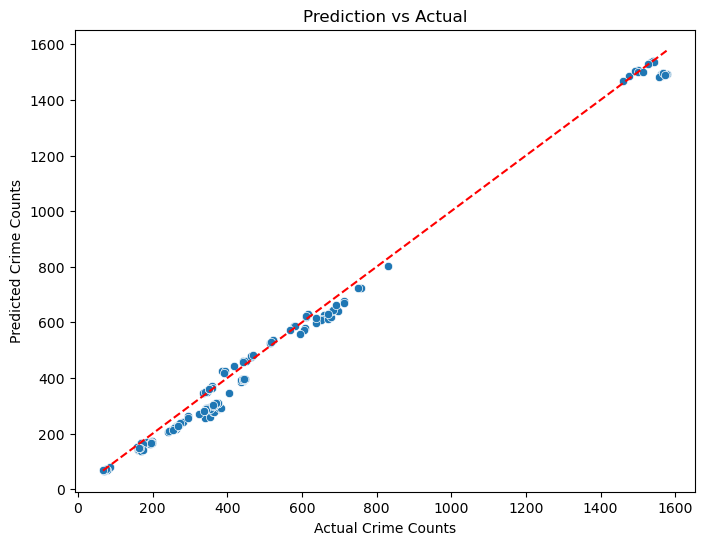

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Crime Counts")
plt.ylabel("Predicted Crime Counts")
plt.title("Prediction vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()


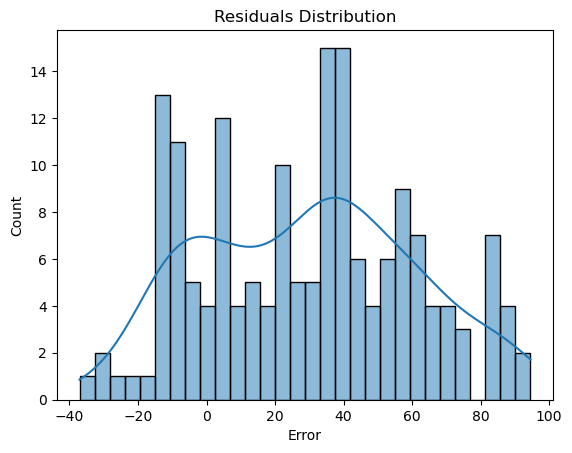

In [96]:
residuals = y_test - y_pred
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Error")
plt.show()
